In [2]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for our testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

In [3]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        input_dim: the dimension of the input vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, input_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(input_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, input_dim)
        '''
        x = noise.view(len(noise), self.input_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, input_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, input_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        input_dim: the dimension of the input vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, input_dim, device=device)

In [4]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
      im_chan: the number of channels in the images, fitted for the dataset used, a scalar
            (MNIST is black-and-white, so 1 channel is your default)
      hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of the DCGAN; 
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [5]:
import torch.nn.functional as F
def get_one_hot_labels(labels, n_classes):
    '''
    Function for creating one-hot vectors for the labels, returns a tensor of shape (?, num_classes).
    Parameters:
        labels: tensor of labels from the dataloader, size (?)
        n_classes: the total number of classes in the dataset, an integer scalar
    '''
    return F.one_hot(labels, n_classes)

In [6]:
def combine_vectors(x, y):
    '''
    Function for combining two vectors with shapes (n_samples, ?) and (n_samples, ?).
    Parameters:
      x: (n_samples, ?) the first vector. 
        In this assignment, this will be the noise vector of shape (n_samples, z_dim), 
        but you shouldn't need to know the second dimension's size.
      y: (n_samples, ?) the second vector.
        Once again, in this assignment this will be the one-hot class vector 
        with the shape (n_samples, n_classes), but you shouldn't assume this in your code.
    '''
    # Note: Make sure this function outputs a float no matter what inputs it receives
    combined = torch.cat((x.float(), y.float()), 1)
    return combined

In [7]:
combined = combine_vectors(torch.tensor([[1, 2], [3, 4]]), torch.tensor([[5, 6], [7, 8]]));
# Check exact order of elements
assert torch.all(combined == torch.tensor([[1, 2, 5, 6], [3, 4, 7, 8]]))
# Tests that items are of float type
assert (type(combined[0][0].item()) == float)
# Check shapes
combined = combine_vectors(torch.randn(1, 4, 5), torch.randn(1, 8, 5));
assert tuple(combined.shape) == (1, 12, 5)
assert tuple(combine_vectors(torch.randn(1, 10, 12).long(), torch.randn(1, 20, 12).long()).shape) == (1, 30, 12)

# Train

* criterion: the loss function
* n_epochs: the number of times you iterate through the entire dataset when training
* z_dim: the dimension of the noise vector
* display_step: how often to display/visualize the images
* batch_size: the number of images per forward/backward pass
* lr: the learning rate
* device: the device type

* mnist_shape: the number of pixels in each MNIST image, which has dimensions 28 x 28 and one channel (because it's black-and-white) so 1 x 28 x 28
* n_classes: the number of classes in MNIST (10, since there are the digits from 0 to 9)

In [8]:
mnist_shape = (1, 28, 28)
n_classes = 10

In [17]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 50
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
device = 'cuda'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [18]:
def get_input_dimensions(z_dim, mnist_shape, n_classes):
    '''
    Function for getting the size of the conditional input dimensions 
    from z_dim, the image shape, and number of classes.
    Parameters:
        z_dim: the dimension of the noise vector, a scalar
        mnist_shape: the shape of each MNIST image as (C, W, H), which is (1, 28, 28)
        n_classes: the total number of classes in the dataset, an integer scalar
                (10 for MNIST)
    Returns: 
        generator_input_dim: the input dimensionality of the conditional generator, 
                          which takes the noise and class vectors
        discriminator_im_chan: the number of input channels to the discriminator
                            (e.g. C x 28 x 28 for MNIST)
    '''
    generator_input_dim = z_dim + n_classes
    discriminator_im_chan = mnist_shape[0] + n_classes
    return generator_input_dim, discriminator_im_chan

In [19]:
def test_input_dims():
    gen_dim, disc_dim = get_input_dimensions(23, (12, 23, 52), 9)
    assert gen_dim == 32
    assert disc_dim == 21
test_input_dims()

In [20]:
generator_input_dim, discriminator_im_chan = get_input_dimensions(z_dim, mnist_shape, n_classes)

gen = Generator(input_dim=generator_input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(im_chan=discriminator_im_chan).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

  0%|          | 0/469 [00:00<?, ?it/s]

Congratulations! If you've gotten here, it's working. Please let this train until you're happy with how the generated numbers look, and then go on to the exploration!


  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 2.365150364279747, discriminator loss: 0.2640260094590485


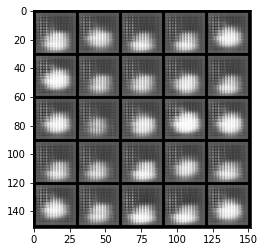

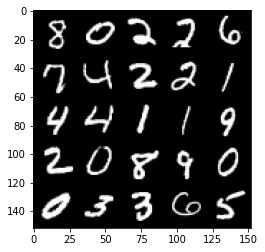

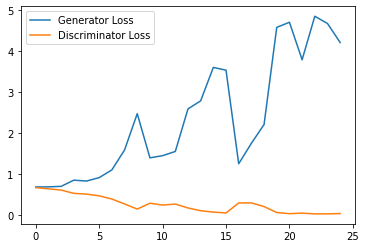

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 4.522528513908386, discriminator loss: 0.08192530799470842


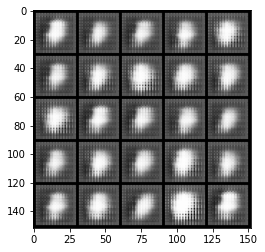

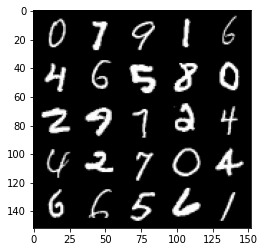

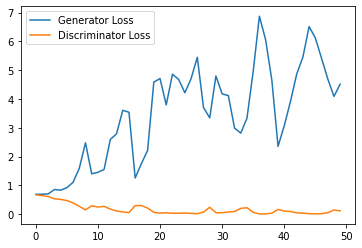

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 5.329367602348328, discriminator loss: 0.023284628960303963


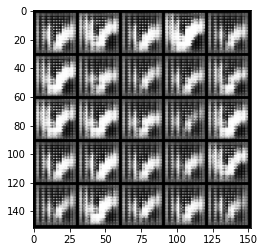

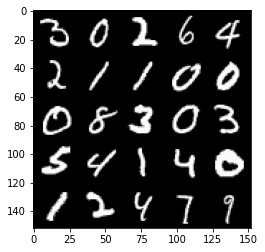

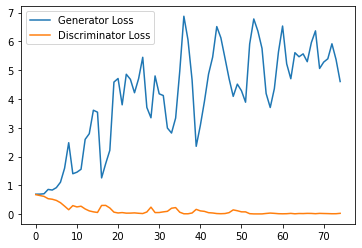

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 4.824507606506348, discriminator loss: 0.04189383978769183


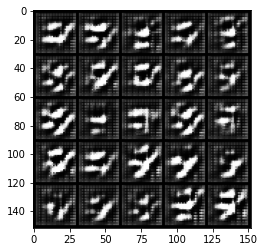

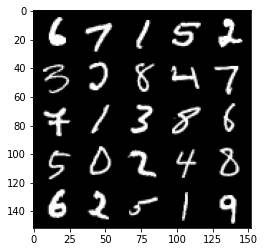

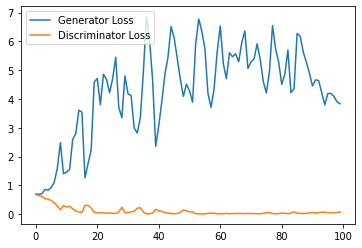

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 4.074205446243286, discriminator loss: 0.09033066490478814


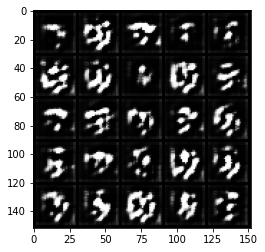

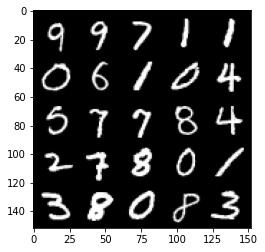

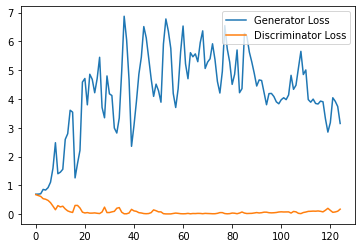

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 2.6876816382408144, discriminator loss: 0.21788071221113206


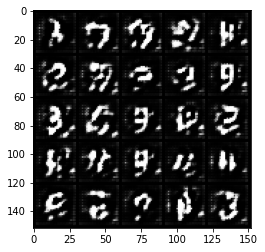

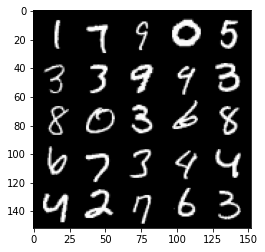

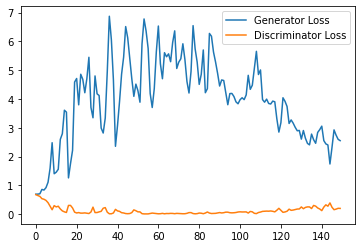

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator loss: 2.3408728210926055, discriminator loss: 0.2577577450275421


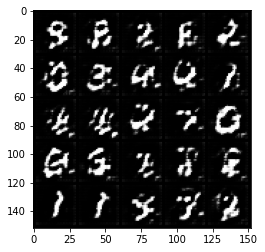

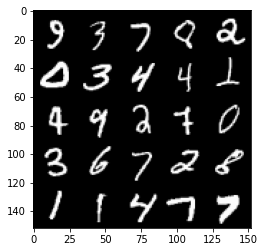

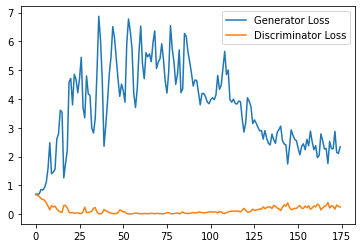

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 2.3561245074272157, discriminator loss: 0.35092467749118805


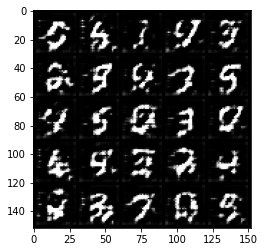

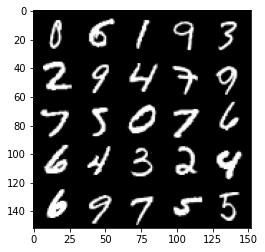

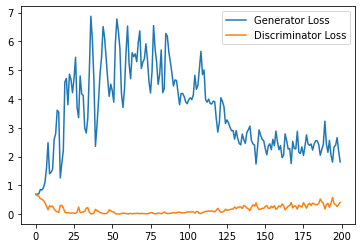

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 1.858902324438095, discriminator loss: 0.3308706352710724


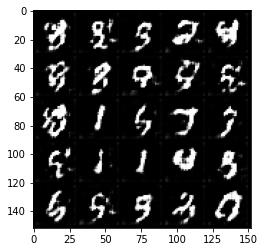

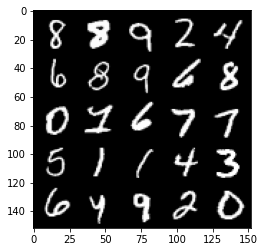

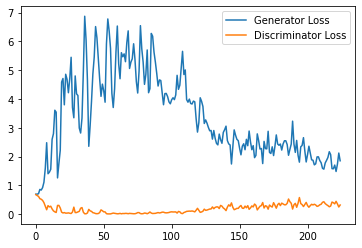

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 1.8053294892311096, discriminator loss: 0.35641875979304316


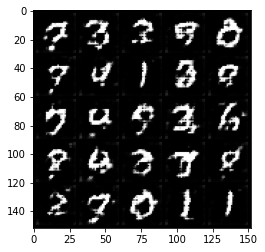

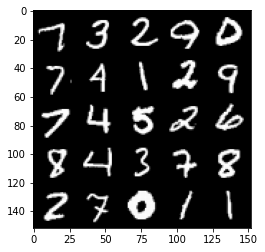

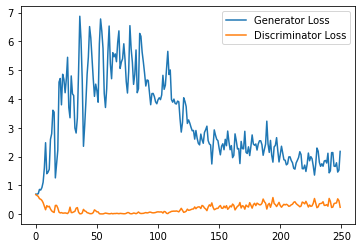

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500: Generator loss: 1.8455939280986786, discriminator loss: 0.3596771250665188


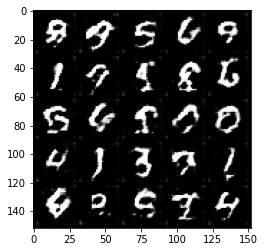

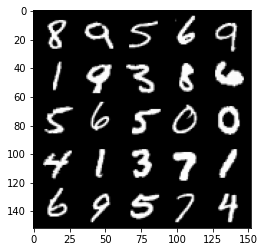

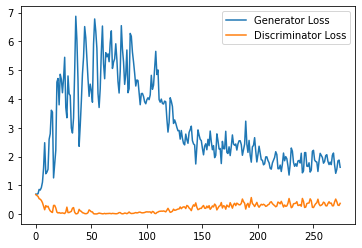

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 1.7372481648921967, discriminator loss: 0.3885689440667629


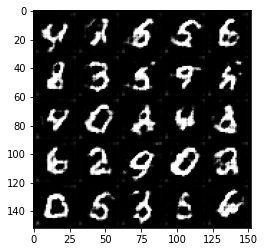

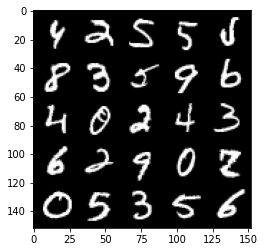

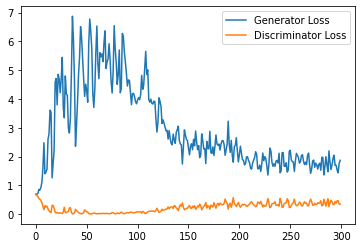

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6500: Generator loss: 1.7238686965703964, discriminator loss: 0.4159846610724926


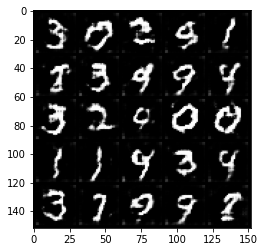

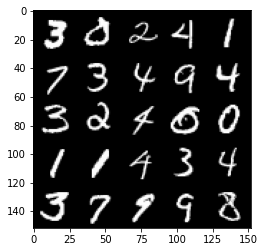

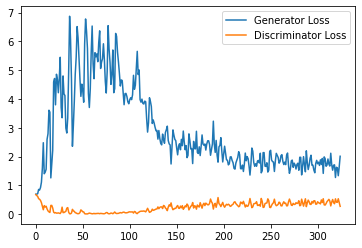

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator loss: 1.5264366643428802, discriminator loss: 0.44020056337118146


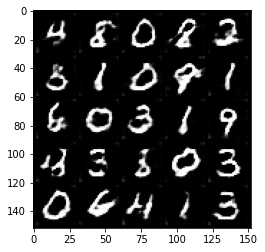

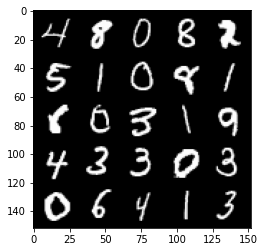

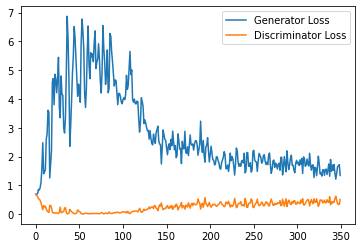

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500: Generator loss: 1.3719680327177048, discriminator loss: 0.4803123763799667


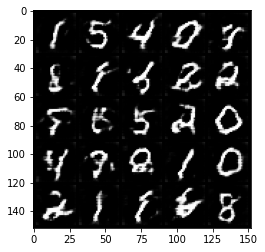

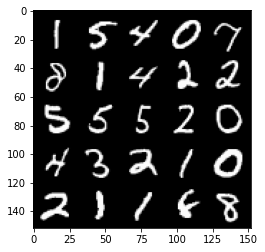

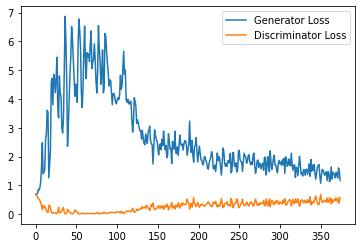

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator loss: 1.3294556758403777, discriminator loss: 0.507047105282545


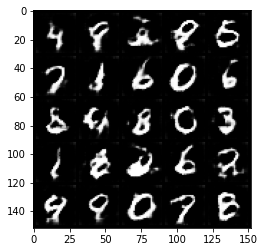

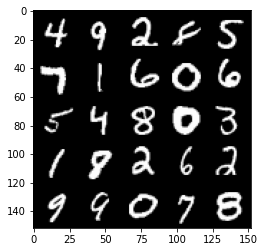

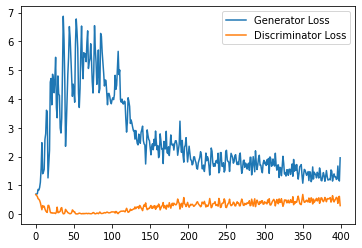

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8500: Generator loss: 1.286474261045456, discriminator loss: 0.5440352618694305


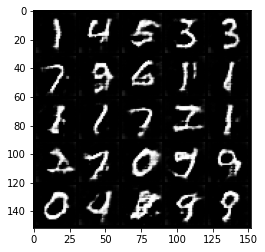

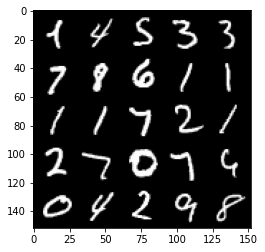

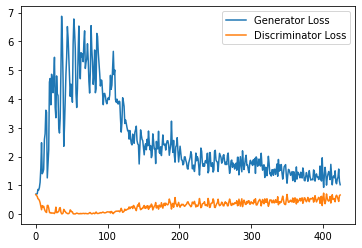

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 1.2967246500253677, discriminator loss: 0.5420320200920105


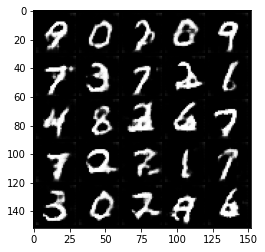

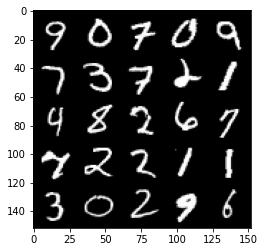

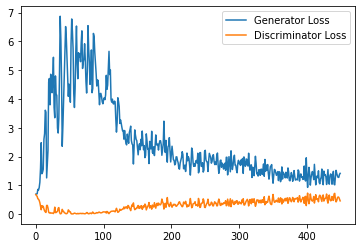

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9500: Generator loss: 1.2094270930290223, discriminator loss: 0.5400290253758431


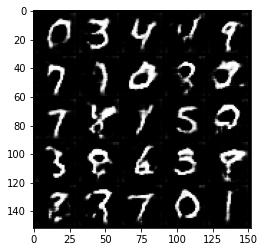

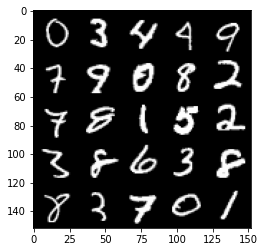

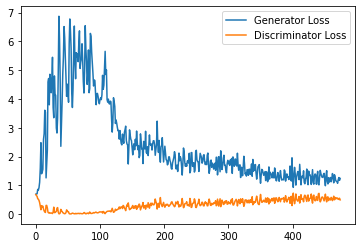

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000: Generator loss: 1.1787367355823517, discriminator loss: 0.5520752790570259


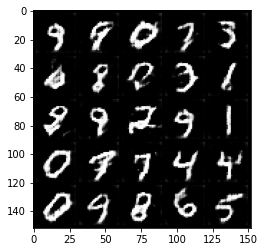

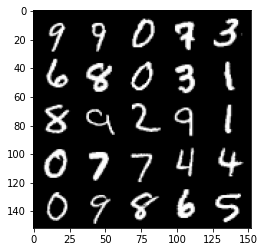

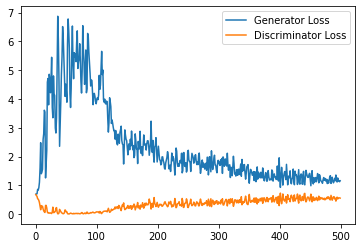

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10500: Generator loss: 1.274267977952957, discriminator loss: 0.5575263244509697


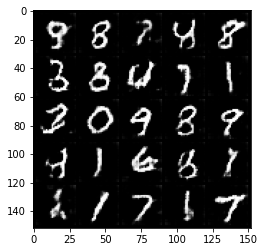

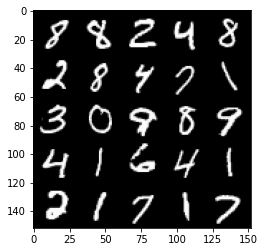

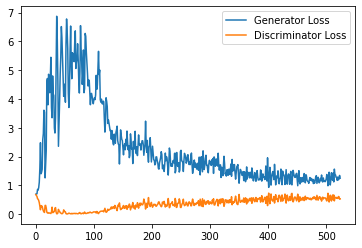

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11000: Generator loss: 1.1751975862979889, discriminator loss: 0.5680989779233933


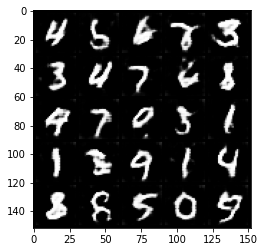

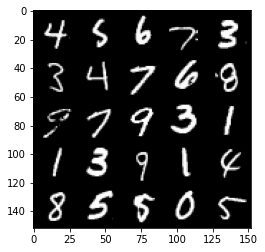

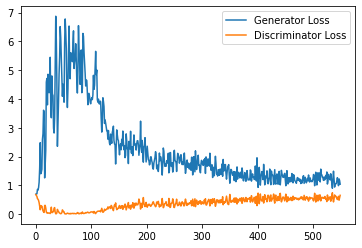

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11500: Generator loss: 1.075514950990677, discriminator loss: 0.5757023249268531


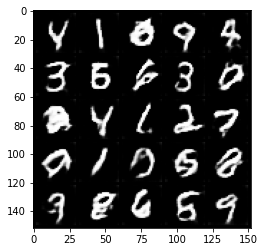

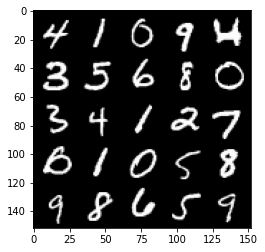

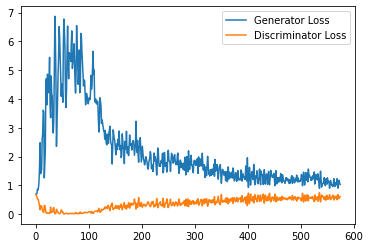

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12000: Generator loss: 1.113671589255333, discriminator loss: 0.5739324616193772


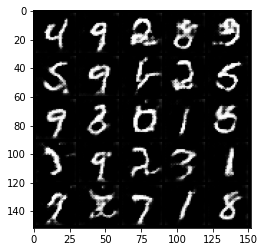

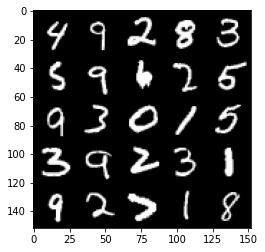

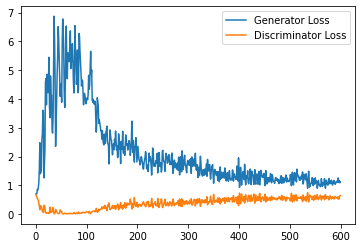

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12500: Generator loss: 1.203832268834114, discriminator loss: 0.5672894343137741


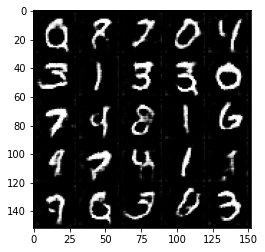

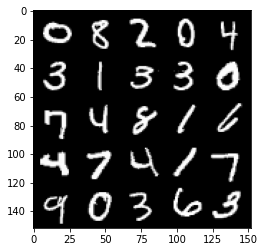

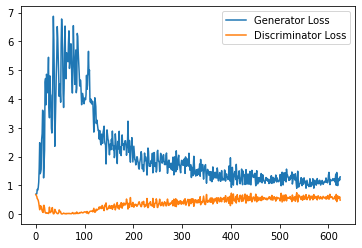

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13000: Generator loss: 1.1261036590337754, discriminator loss: 0.5676763453483582


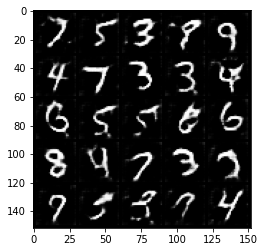

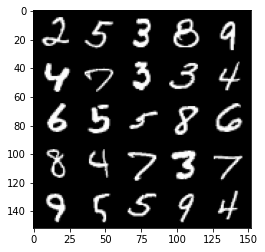

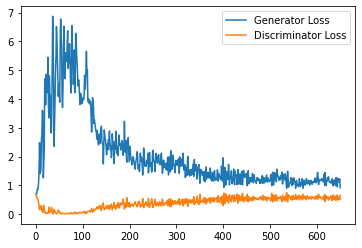

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13500: Generator loss: 1.1196354157924653, discriminator loss: 0.5781850225329399


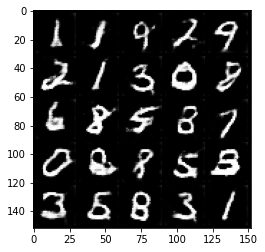

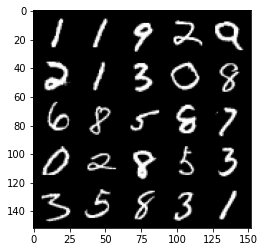

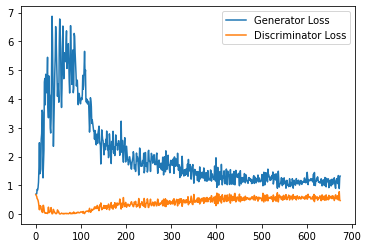

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14000: Generator loss: 1.106538988828659, discriminator loss: 0.5752445542812348


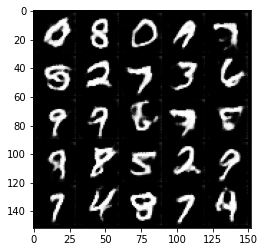

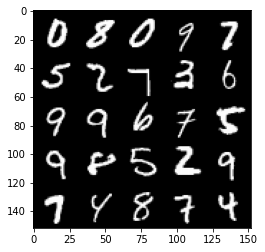

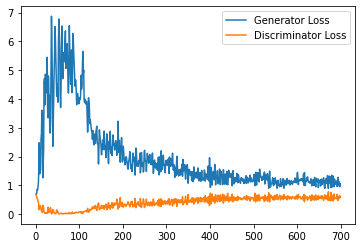

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14500: Generator loss: 1.0909976907968522, discriminator loss: 0.5805364246368409


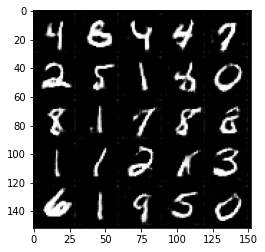

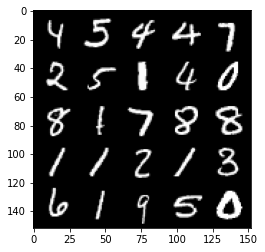

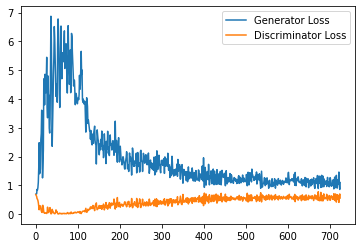

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15000: Generator loss: 1.0551193087100983, discriminator loss: 0.5802475196123124


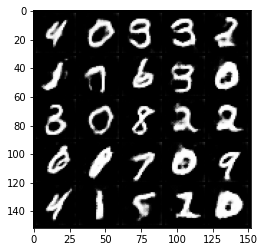

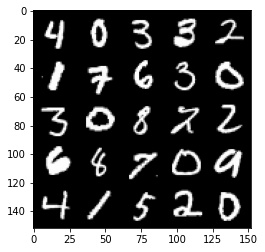

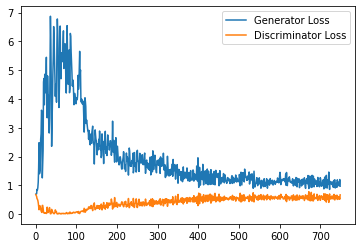

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15500: Generator loss: 1.075269131064415, discriminator loss: 0.5780814544558525


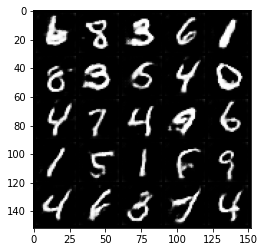

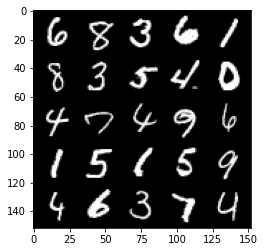

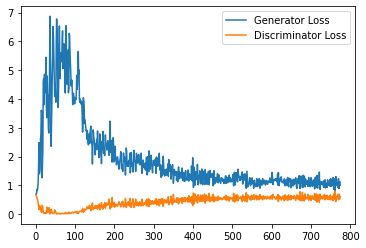

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16000: Generator loss: 1.0484903029203414, discriminator loss: 0.5958010658621788


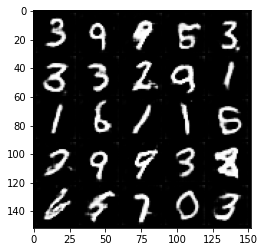

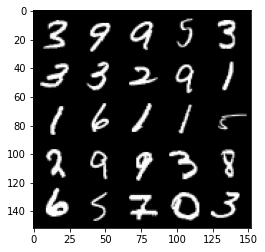

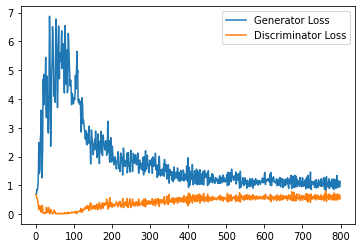

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16500: Generator loss: 1.012884517431259, discriminator loss: 0.6016322576403618


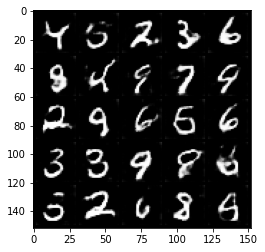

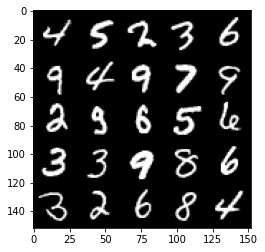

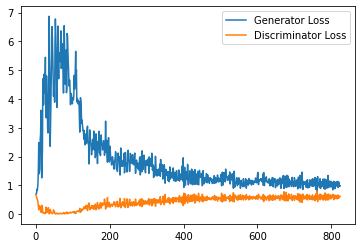

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17000: Generator loss: 1.0375936555862426, discriminator loss: 0.5915895650982856


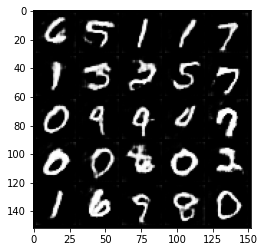

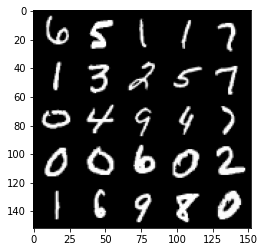

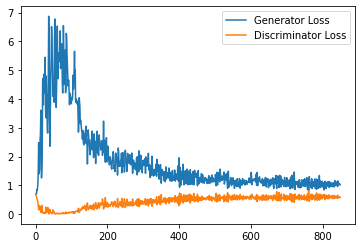

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17500: Generator loss: 1.0309494352340698, discriminator loss: 0.5910671380162239


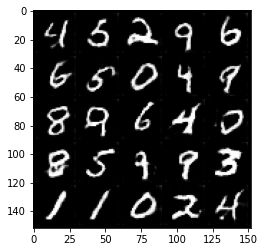

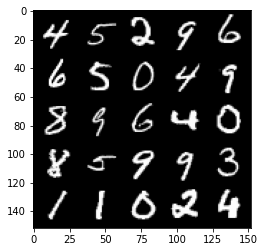

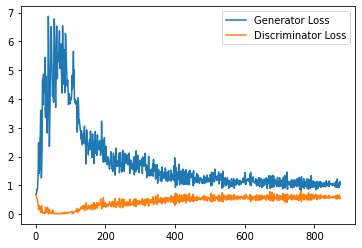

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18000: Generator loss: 1.01535367000103, discriminator loss: 0.5968031970858574


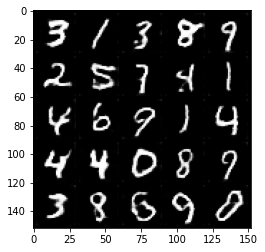

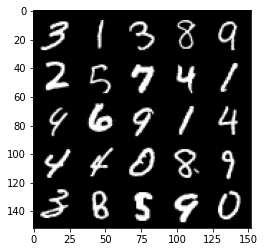

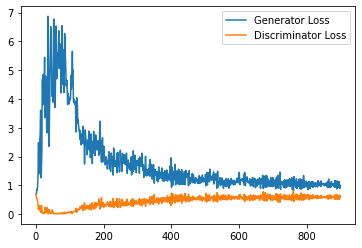

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18500: Generator loss: 0.972530808210373, discriminator loss: 0.5990636374950409


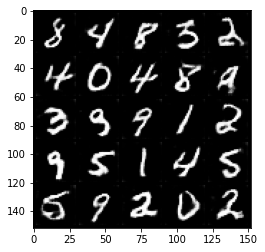

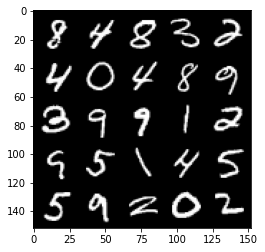

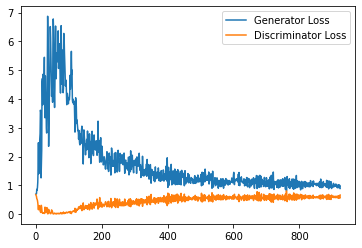

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19000: Generator loss: 1.0009568965435027, discriminator loss: 0.5980749510526657


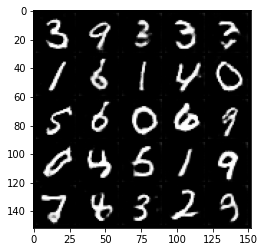

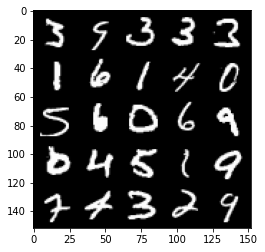

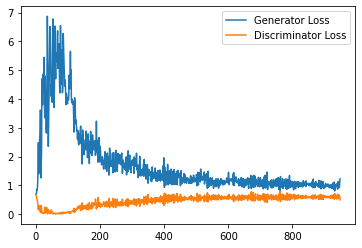

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19500: Generator loss: 0.9815397630929947, discriminator loss: 0.6034064230918884


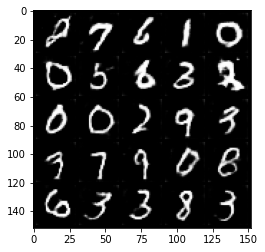

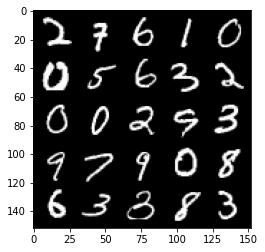

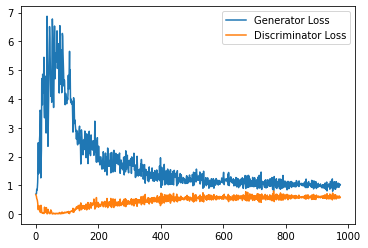

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20000: Generator loss: 1.0003647145032883, discriminator loss: 0.6022751879692078


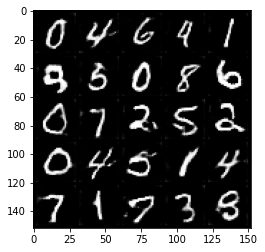

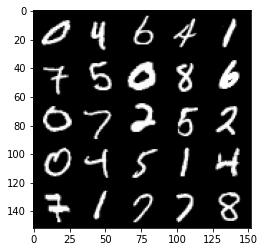

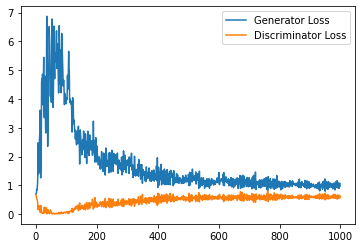

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20500: Generator loss: 0.9850298454761505, discriminator loss: 0.601821131825447


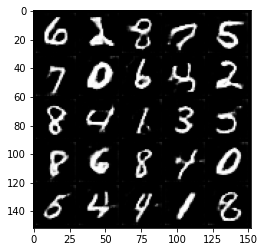

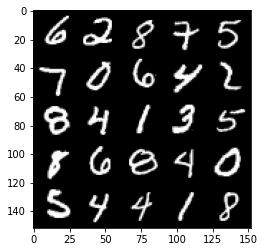

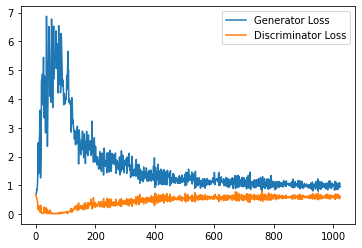

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21000: Generator loss: 1.0051391026973724, discriminator loss: 0.60139223331213


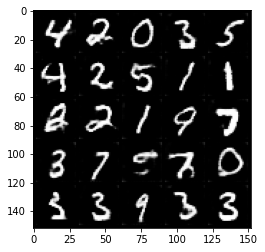

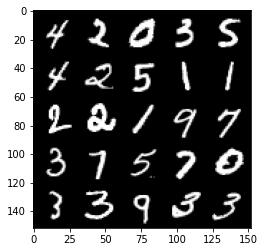

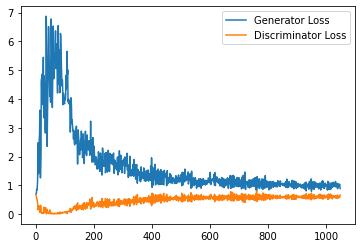

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21500: Generator loss: 0.9871198265552521, discriminator loss: 0.602341071665287


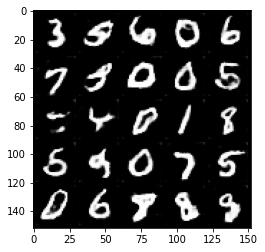

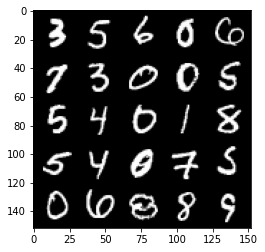

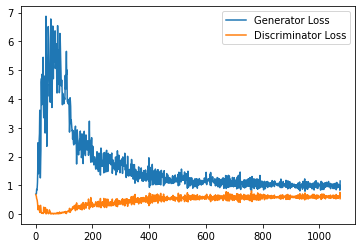

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22000: Generator loss: 0.97481023478508, discriminator loss: 0.6103816835284233


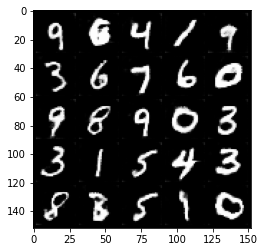

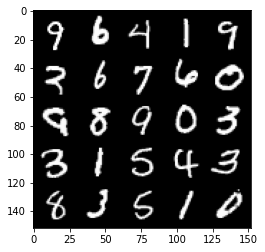

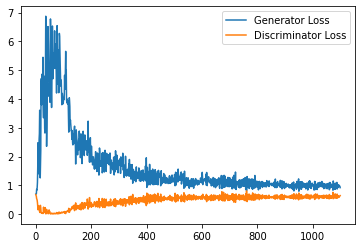

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22500: Generator loss: 0.9778559129238129, discriminator loss: 0.6042522804141045


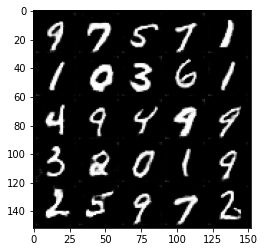

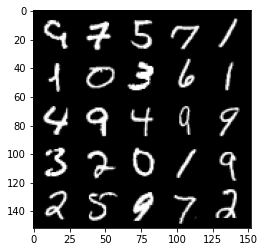

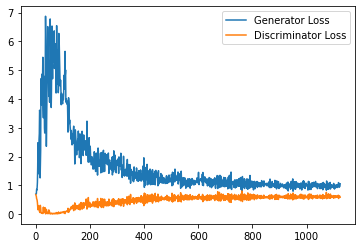

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 23000: Generator loss: 0.9708045138120651, discriminator loss: 0.6119254233241082


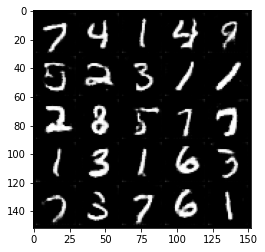

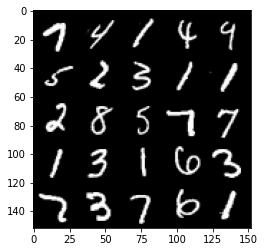

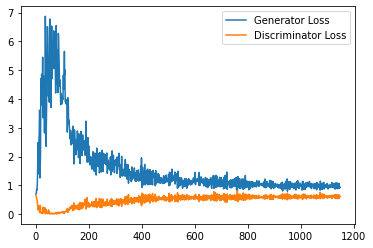

In [21]:
cur_step = 0
generator_losses = []
discriminator_losses = []

noise_and_labels = False
fake = False

fake_image_and_labels = False
real_image_and_labels = False
disc_fake_pred = False
disc_real_pred = False

for epoch in range(n_epochs):
    # Dataloader returns the batches and the labels
    for real, labels in tqdm(dataloader):
        cur_batch_size = len(real)
        # Flatten the batch of real images from the dataset
        real = real.to(device)

        one_hot_labels = get_one_hot_labels(labels.to(device), n_classes)
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = image_one_hot_labels.repeat(1, 1, mnist_shape[1], mnist_shape[2])

        ### Update discriminator ###
        # Zero out the discriminator gradients
        disc_opt.zero_grad()
        # Get noise corresponding to the current batch_size 
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        
       
        noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
        fake = gen(noise_and_labels)
        
        # Make sure that enough images were generated
        assert len(fake) == len(real)
        # Check that correct tensors were combined
        assert tuple(noise_and_labels.shape) == (cur_batch_size, fake_noise.shape[1] + one_hot_labels.shape[1])
        # It comes from the correct generator
        assert tuple(fake.shape) == (len(real), 1, 28, 28)

        # Now you can get the predictions from the discriminator
        
        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)
        real_image_and_labels = combine_vectors(real, image_one_hot_labels)
        disc_fake_pred = disc(fake_image_and_labels.detach())
        disc_real_pred = disc(real_image_and_labels)
        
        # Make sure shapes are correct 
        assert tuple(fake_image_and_labels.shape) == (len(real), fake.detach().shape[1] + image_one_hot_labels.shape[1], 28 ,28)
        assert tuple(real_image_and_labels.shape) == (len(real), real.shape[1] + image_one_hot_labels.shape[1], 28 ,28)
        # Make sure that enough predictions were made
        assert len(disc_real_pred) == len(real)
        # Make sure that the inputs are different
        assert torch.any(fake_image_and_labels != real_image_and_labels)
        # Shapes must match
        assert tuple(fake_image_and_labels.shape) == tuple(real_image_and_labels.shape)
        assert tuple(disc_fake_pred.shape) == tuple(disc_real_pred.shape)
        
        
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph=True)
        disc_opt.step() 

        # Keep track of the average discriminator loss
        discriminator_losses += [disc_loss.item()]

        ### Update generator ###
        # Zero out the generator gradients
        gen_opt.zero_grad()

        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)
        # This will error if you didn't concatenate your labels to your image correctly
        disc_fake_pred = disc(fake_image_and_labels)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the generator losses
        generator_losses += [gen_loss.item()]
        #

        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()
        elif cur_step == 0:
            print("Congratulations! If you've gotten here, it's working. Please let this train until you're happy with how the generated numbers look, and then go on to the exploration!")
        cur_step += 1

In [22]:
gen = gen.eval()

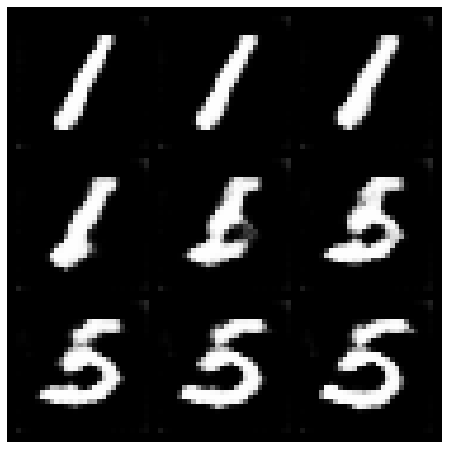

In [23]:
import math

n_interpolation = 9 # Choose the interpolation: how many intermediate images you want + 2 (for the start and end image)
interpolation_noise = get_noise(1, z_dim, device=device).repeat(n_interpolation, 1)

def interpolate_class(first_number, second_number):
    first_label = get_one_hot_labels(torch.Tensor([first_number]).long(), n_classes)
    second_label = get_one_hot_labels(torch.Tensor([second_number]).long(), n_classes)

    # Calculate the interpolation vector between the two labels
    percent_second_label = torch.linspace(0, 1, n_interpolation)[:, None]
    interpolation_labels = first_label * (1 - percent_second_label) + second_label * percent_second_label

    # Combine the noise and the labels
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_labels.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images=n_interpolation, nrow=int(math.sqrt(n_interpolation)), show=False)

start_plot_number = 1
end_plot_number = 5

plt.figure(figsize=(8, 8))
interpolate_class(start_plot_number, end_plot_number)
_ = plt.axis('off')

# plot_numbers = [2, 3, 4, 5, 7]
# n_numbers = len(plot_numbers)
# plt.figure(figsize=(8, 8))
# for i, first_plot_number in enumerate(plot_numbers):
#     for j, second_plot_number in enumerate(plot_numbers):
#         plt.subplot(n_numbers, n_numbers, i * n_numbers + j + 1)
#         interpolate_class(first_plot_number, second_plot_number)
#         plt.axis('off')
# plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.1, wspace=0)
# plt.show()
# plt.close()

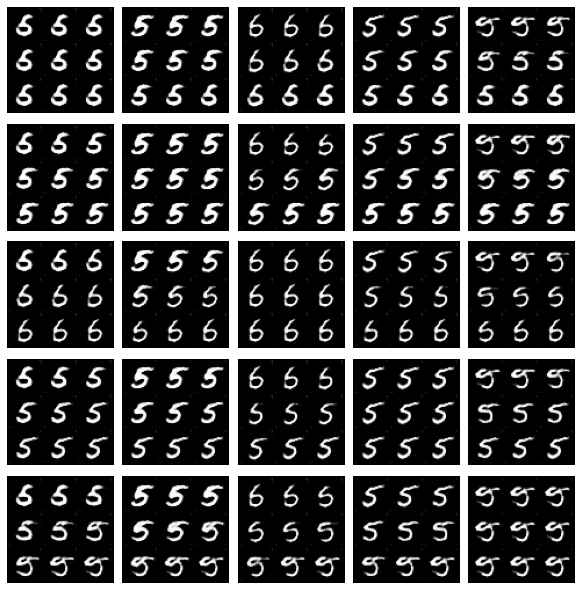

In [25]:
n_interpolation = 9

interpolation_label = get_one_hot_labels(torch.Tensor([5]).long(), n_classes).repeat(n_interpolation, 1).float()

def interpolate_noise(first_noise, second_noise):
    # This time you're interpolating between the noise instead of the labels
    percent_first_noise = torch.linspace(0, 1, n_interpolation)[:, None].to(device)
    interpolation_noise = first_noise * percent_first_noise + second_noise * (1 - percent_first_noise)

    # Combine the noise and the labels again
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_label.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images=n_interpolation, nrow=int(math.sqrt(n_interpolation)), show=False)

# Generate noise vectors to interpolate between
n_noise = 5 # Choose the number of noise examples in the grid
plot_noises = [get_noise(1, z_dim, device=device) for i in range(n_noise)]
plt.figure(figsize=(8, 8))
for i, first_plot_noise in enumerate(plot_noises):
    for j, second_plot_noise in enumerate(plot_noises):
        plt.subplot(n_noise, n_noise, i * n_noise + j + 1)
        interpolate_noise(first_plot_noise, second_plot_noise)
        plt.axis('off')
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.1, wspace=0)
plt.show()
plt.close()